In [4]:
import os
import sagemaker

from sagemaker.xgboost import XGBoost
from sagemaker import get_execution_role

CREATE FOLDER TO SAVE TRAINING CODE

In [5]:
os.makedirs("training_code_08", exist_ok=True) # Create folder for training code

CREATE TRAINING ENTRY POINT

Everyt file that will be save in the folder os.environ['SM_OUTPUT_DATA_DIR'] will be available afterwards.
The whole folder is packed into tar.gz and copied into the outut folder

In [6]:
%%writefile training_code_08/train.py

from __future__ import print_function

import argparse
import joblib
import os
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Accessing additional arguments from environment variables
    additional_arg1 = os.environ['ADDITIONAL_ARG1']
    additional_arg2 = os.environ['ADDITIONAL_ARG2']
    
    # Hyperparameters
    parser.add_argument('--max_depth', type=int, default=5)
    parser.add_argument('--n_estimators', type=int, default=100)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    parser.add_argument('--objective', type=str, default='binary:logistic')

    args = parser.parse_args()

    model_dir = os.environ['SM_MODEL_DIR'] # Folder where model must be saved
    train_dir = os.environ['SM_CHANNEL_TRAIN'] # Folder where train data is stored
    output_dir = os.environ['SM_OUTPUT_DATA_DIR']
    
    # Lets assume there is only one training file
    train_file_name = os.listdir(train_dir)[0]
    train_file_path = os.path.join(train_dir, train_file_name)
    train_data = pd.read_csv(train_file_path, header=None, engine="python")
    
    # Separate features and labels
    train_y = train_data.iloc[:, 0]
    train_X = train_data.iloc[:, 1:]  

    # Track training results
    eval_results = {}

    # Train the model
    clf = xgb.XGBClassifier(
        max_depth=args.max_depth,
        n_estimators=args.n_estimators,
        learning_rate=args.learning_rate,
        objective=args.objective)
    clf.fit(train_X, train_y, eval_set=[(train_X, train_y)], eval_metric="logloss", early_stopping_rounds=10, verbose=True, callbacks=[xgb.callback.record_evaluation(eval_results)])

    # Save the model
    clf.get_booster().save_model(os.path.join(model_dir, "model.xgb"))

    # Create and save the chart
    epochs = len(eval_results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, eval_results['validation_0']['logloss'], label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.legend()
    plt.grid(True)

    # Save the figure
    plt.savefig(os.path.join(output_dir, "training_log_loss.png"))
    plt.close()

    print(additional_arg1)
    print(additional_arg2)

Writing training_code_08/train.py


CREATE NECCESSARY OBJECTS

In [7]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

CREATE ESTIMATOR OBJECT

In [8]:
hyperparameters = {
    'max_depth': 3,
    'n_estimators': 8,
    'learning_rate': 0.25,
    'objective': 'binary:logistic',  # example objective for a binary classification task
}

environment = {
    'ADDITIONAL_ARG1': 'To jest wartosc 1',
    'ADDITIONAL_ARG2': 'Wartosc 2'
}

xgboost = XGBoost(
    entry_point='train.py', # The file with the training code
    source_dir='training_code_08', # The folder with the training code
    hyperparameters=hyperparameters, # Hyperparameters for the model
    framework_version='1.3-1', # Version of XGBoost which will be used
    instance_type='ml.m5.large', # Instance type that will be used
    instance_count=1, # Number of instances to train
    role=role, # Role that will be used during execution
    sagemaker_session=sagemaker_session, 
    base_job_name='xgboost-08', # Name of the training job. Timestamp will be added as suffix
    environment=environment
)


FIT THE MODEL
- The fit function have one required parameter in the form of a dictionary.
- The key represents the "channel" of the data. Typically it is train, test, valid. The names can be arbitrary.
- The value contains path to S3 folder that contains the data

The data from all channels will be copied to the training instance.

To obtain LOCAL path to the data one should use os.environ['SM_CHANNEL_CHANNEL'] and replace CHANNEL by actual channel name

Example:

If we specify following dictionary {"train": "s3://sagemaker-bucket-ds/training-jobs/data/train/"} then in the training script the path to the training data is in the object os.environ['SM_CHANNEL_TRAIN']


In [9]:
xgboost.fit({"train": "s3://sagemaker-bucket-ds/training-jobs/data/train/"})

INFO:sagemaker:Creating training-job with name: xgboost-08-2024-06-27-14-18-33-487


2024-06-27 14:18:34 Starting - Starting the training job...
2024-06-27 14:18:50 Starting - Preparing the instances for training...
2024-06-27 14:19:17 Downloading - Downloading input data...
2024-06-27 14:20:02 Downloading - Downloading the training image......
2024-06-27 14:20:53 Training - Training image download completed. Training in progress.
2024-06-27 14:20:53 Uploading - Uploading generated training model[2024-06-27 14:20:48.089 ip-10-0-176-240.eu-west-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-27 14:20:48.113 ip-10-0-176-240.eu-west-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-27:14:20:48:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-27:14:20:48:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-27:14:20:48:INFO] Invoking user training script.
[2024-06-27:14:20:48:INFO] Module train does not provide a setup.py. 
Generating setup.py
[2024-06-27:14:20:48:

Environment variables are saved
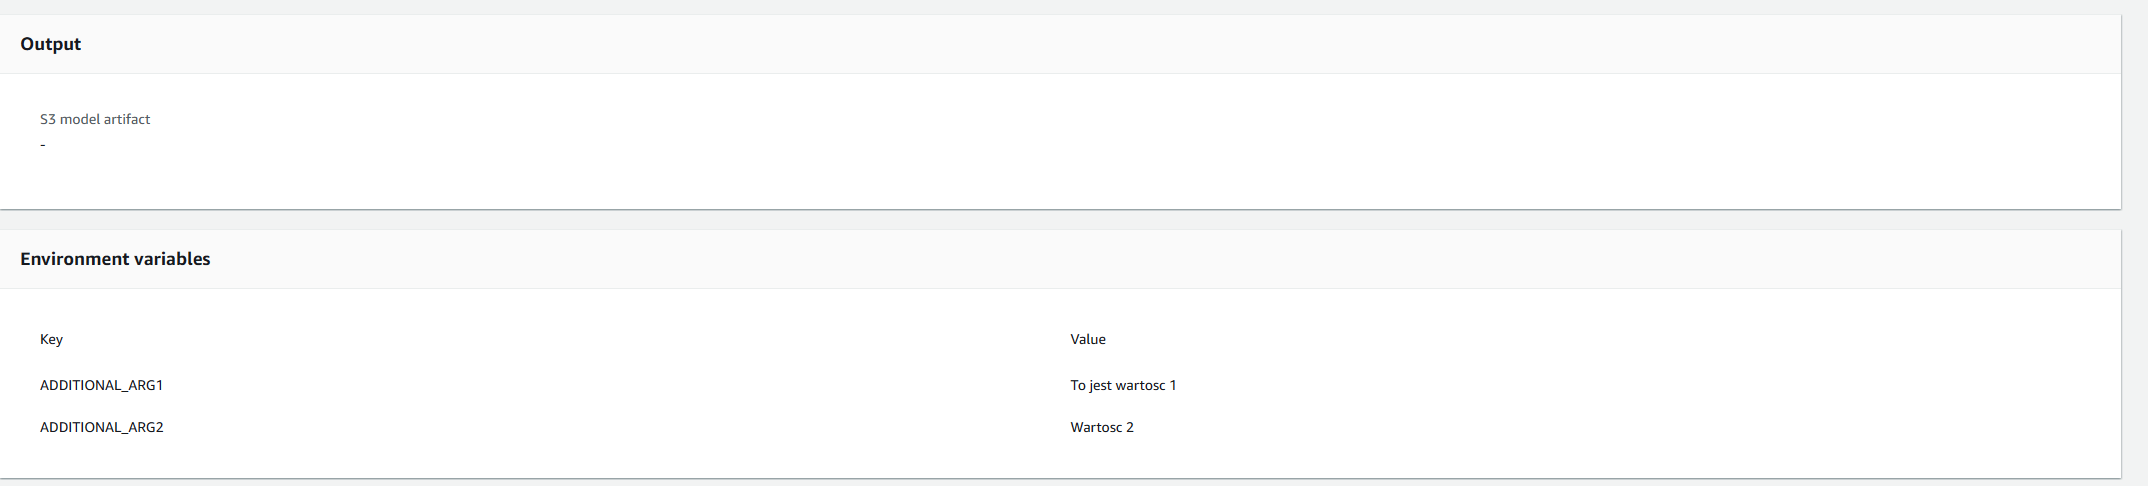
